# Airbnb Pricing Prediction: Final
**James Gearheart**<br>
**Danny Zhuang**<br>
**Bob Saludo**<br>
**Ryan Wallace**<br><br>
**Harvard University**<br>
**Fall 2016**<br>
**TF: Christine Hwang**<br>

# TODO
ridge regression and tuning

lasso regression and tuning

random forest regression and tuning

comparison on test set of the final ridge, lasso, and random forest models to choose best overall

prediction intervals around predictions

---

## Explanation of Modelling Choices Made in this Part
### Additional Categorical Variables Created
It is clear from the visualization of average price against the day of the year that first three months of the year see lower average prices than the remaineder of the year (with the exception of around New Years). Previously, this was incorporated into the model by including a cateorical variable indicating whether each observation fell in this slump period. However, it can also be seen that even during the slump, it appears that some months (partiuclarly January) are worse than others. Thus, we also create three new categorical variables for each of January, February, and March to incorporate more time-related nuance into the model.

We chose to preserve the quartile representation of zipcodes and neighborhoods, since we fear that including more specific indicators (such as for each zipcode) would lead to drastic overfitting. On examining other approaches for the encoding of these variables, we come to realize that other clustering approaches such as K-means is not suited to this task since we are dealing with categorical data that can not be grouped well in a continuous fashion.

Indicators were also created for each of the property types, each of the room types, and each of the bed types. Since each of these categories has relatively few distinct values, it seems that creating one indicator for each distinct value is less likely to lead to severe overfitting or over-complication of the model. Nevertheless, it will be important to perform regularization to avoid potential overfitting.

### Transformations and Interactions
Each of the continuous variables is plotted against the response variable, the log of price, in order to determine if there are significant non-linear relationships between the variables. From the plots, we see that a quadratic term for  longitude, host listing count, and the value rating produce a more linear relationship with log price, so these transformations are generated.

Since an exhuastive search of possible interaction terms to include would involve roughly $\binom{70}{2} = 2415$ interactions to examine, this approach is not feasible computationally. Instead, we rely on our intuitive understanding of the relationships between the variables to anticiapte which interaction terms would be meaningful. Using this approach, we include interactions for both weekend and holiday with both number of bedrooms and number of guests accomodated. This interaction seems potentially reasonable because one could imagine that in particularly high demand times, larger or more accomodating properties are especially valuable.

### General Modelling Approach and Assumptions Possibly Violated
We choose to model our data by including a single observation for each listing for each day it is offered. This is potentially problematic for two reasons. Firstly, it violates OLS assumption that each observation is independent, because it is obvious that the listings for a given property on different days are highly dependent. Secondly, this may bias our regressions such that the relationships present in properties that are offered more regularly are more highly weighted.

Despite these potential violations, we maintain this data representation because it fully encodes the all of the information we have, both related to the properties, the time of year, and the relationship between properties and the time of year (which we exploit in creating some interaction variables, as described above). We feel that it is reasonable to potentially violate the i.i.d. assumption since the size of our data set is so large (millions of listings) compared to the size of the sets of dependent observations (maximum size of 365). Additionally, we feel that biasing the results towards properties that are more frequently offered is not necessarily detrimental, since we expect these types of properties to be offered more frequently in the future as well, leading to potentially better performance on future test sets.

In [1]:
# import necessary libraries
import csv
import datetime
import operator
import random
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib
import matplotlib.pyplot as plt
from sklearn.cross_validation import KFold
from sklearn.linear_model import LinearRegression as LinReg
from sklearn.linear_model import Ridge as Ridge_Reg
from sklearn.linear_model import Lasso as Lasso_Reg
from sklearn.ensemble import RandomForestRegressor as RandomForest
from sklearn import preprocessing
from sklearn.cluster import KMeans
%matplotlib inline

In [2]:
# read the three cleaned datasets
listings_df = pd.read_csv('datasets/listings_final.csv', delimiter=',', index_col=0)
reviews_df = pd.read_csv('datasets/reviews_final.csv', delimiter=',', index_col=0)
calendar_df = pd.read_csv('datasets/calendar_final.csv', index_col=0)

# log transform prices in calendar
calendar_df['price_log'] = np.log(calendar_df['price'])

/Applications/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (0,2,6,17) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
calendar_df.drop(['available'], axis=1, inplace=True, errors='ignore')
listings_df.drop(['scrape_id', 'last_scraped', 'name', 'picture_url', 'host_id', 'host_name', 'host_since',
                  'host_picture_url', 'weekly_price', 'monthly_price', 'calendar_last_scraped', 'calendar_updated',
                  'street', 'market', 'extra_people'], axis=1, inplace=True, errors='ignore')

In [4]:
# create calendar with listings data added
calendar_expanded_df = calendar_df.merge(listings_df, on='listing_id', how='left', suffixes=['_calendar', '_listings'])

In [5]:
# strip errant NaN's and infinites from data import errors and log transformation
print 'calendar entries before stripping:', calendar_expanded_df.shape[0]
calendar_expanded_df = calendar_expanded_df.replace([np.inf, -np.inf], np.nan)
calendar_expanded_df = calendar_expanded_df.dropna()
print 'calendar entries after stripping:', calendar_expanded_df.shape[0]

calendar entries before stripping: 7201883
calendar entries after stripping: 7201153


In [6]:
# method to convert date to day of week
def get_day(date):
    return datetime.datetime.strptime(date, '%Y-%m-%d').strftime('%A')

In [7]:
# create indicators for time variables
# weekend
dates = np.array(calendar_expanded_df['date'])
days = [get_day(date) for date in dates]
weekend = [1 if day == 'Friday' or day == 'Saturday' else 0 for day in days]
calendar_expanded_df['weekend'] = pd.Series(np.array(weekend), index=calendar_expanded_df.index)

# major holidys (around New Years)
holiday_dates = ['2015-01-01', '2015-01-02', '2015-01-03']
holiday = [1 if date in holiday_dates else 0 for date in dates]
calendar_expanded_df['holiday'] = pd.Series(np.array(holiday), index=calendar_expanded_df.index)

# not January (excluding Holidays) or February
slump_dates = []
for d in range(4, 10):
    slump_dates.append('2015-01-0' + str(d))
for d in range(10, 32):
    slump_dates.append('2015-01-' + str(d))
for d in range(1, 10):
    slump_dates.append('2015-02-0' + str(d))
for d in range(10, 29):
    slump_dates.append('2015-01-' + str(d))
slump = [1 if date in slump_dates else 0 for date in dates]
calendar_expanded_df['slump'] = pd.Series(np.array(slump), index=calendar_expanded_df.index)

# Jan (after Jan 3), Feb, and March each appear to have different values
jan_dates = []
feb_dates = []
march_dates = []
for d in range(4, 10):
    jan_dates.append('2015-01-0' + str(d))
for d in range(10, 32):
    jan_dates.append('2015-01-' + str(d))
for d in range(1, 10):
    feb_dates.append('2015-02-0' + str(d))
for d in range(10, 29):
    feb_dates.append('2015-01-' + str(d))
for d in range(1, 10):
    march_dates.append('2015-01-0' + str(d))
for d in range(10, 32):
    march_dates.append('2015-01-' + str(d))
jan = [1 if date in jan_dates else 0 for date in dates]
feb = [1 if date in feb_dates else 0 for date in dates]
march = [1 if date in march_dates else 0 for date in dates]

calendar_expanded_df['jan'] = pd.Series(np.array(jan), index=calendar_expanded_df.index)
calendar_expanded_df['feb'] = pd.Series(np.array(feb), index=calendar_expanded_df.index)
calendar_expanded_df['march'] = pd.Series(np.array(march), index=calendar_expanded_df.index)

In [8]:
# find means by zipcode and group into zipcodes
neighborhoods = calendar_expanded_df['neighbourhood'].unique()
zipcodes = calendar_expanded_df['zipcode'].unique()

neighborhood_prices = []
for neighborhood in neighborhoods:
    neighborhood_prices.append((neighborhood, np.mean(np.array(listings_df[listings_df['neighbourhood'] == neighborhood]['price']))))

zipcode_prices = []
for zipcode in zipcodes:
    zipcode_prices.append((zipcode, np.mean(np.array(listings_df[listings_df['zipcode'] == zipcode]['price']))))
    
# group zipcodes and neighborhoods into quartiles by average
neighborhood_prices.sort(key=operator.itemgetter(1), reverse=True)
zipcode_prices.sort(key=operator.itemgetter(1), reverse=True)

# find size of quartiles
neighborhood_quartile_size = int(np.round(len(neighborhood_prices)*0.25))
zipcode_quartile_size = int(np.round(len(zipcode_prices)*0.25))

# break up neighboorhood and zipcodes by quartile
neighborhood_1 = neighborhood_prices[:neighborhood_quartile_size]
neighborhood_2 = neighborhood_prices[neighborhood_quartile_size:2*neighborhood_quartile_size]
neighborhood_3 = neighborhood_prices[2*neighborhood_quartile_size:3*neighborhood_quartile_size]
neighborhood_4 = neighborhood_prices[3*neighborhood_quartile_size:]

zipcode_1 = zipcode_prices[:zipcode_quartile_size]
zipcode_2 = zipcode_prices[zipcode_quartile_size:2*zipcode_quartile_size]
zipcode_3 = zipcode_prices[2*zipcode_quartile_size:3*zipcode_quartile_size]
zipcode_4 = zipcode_prices[3*zipcode_quartile_size:]

# create new indicators for each quartile
neighborhoods = np.array(calendar_expanded_df['neighbourhood'])
zipcodes = np.array(calendar_expanded_df['zipcode'])

neighborhood_q1 = []
neighborhood_q2 = []
neighborhood_q3 = []
neighborhood_q4 = []

zipcode_q1 = []
zipcode_q2 = []
zipcode_q3 = []
zipcode_q4 = []

for neighborhood in neighborhoods:
    if neighborhood in neighborhood_1:
        neighborhood_q1.append(1)
    else:
        neighborhood_q1.append(0)
    
    if neighborhood in neighborhood_2:
        neighborhood_q2.append(1)
    else:
        neighborhood_q2.append(0)
    
    if neighborhood in neighborhood_3:
        neighborhood_q3.append(1)
    else:
        neighborhood_q3.append(0)
        
    if neighborhood in neighborhood_4:
        neighborhood_q4.append(1)
    else:
        neighborhood_q4.append(0)
        
for zipcode in zipcodes:
    if zipcode in zipcode_1:
        zipcode_q1.append(1)
    else:
        zipcode_q1.append(0)
    
    if zipcode in zipcode_2:
        zipcode_q2.append(1)
    else:
        zipcode_q2.append(0)
    
    if zipcode in zipcode_3:
        zipcode_q3.append(1)
    else:
        zipcode_q3.append(0)
        
    if zipcode in zipcode_4:
        zipcode_q4.append(1)
    else:
        zipcode_q4.append(0)

# convert zipcode, neighborhood lists to np arrays
calendar_expanded_df['zipcode_q1'] = pd.Series(np.array(zipcode_q1))
calendar_expanded_df['zipcode_q2'] = pd.Series(np.array(zipcode_q2))
calendar_expanded_df['zipcode_q3'] = pd.Series(np.array(zipcode_q3))
calendar_expanded_df['zipcode_q4'] = pd.Series(np.array(zipcode_q4))

calendar_expanded_df['neighborhood_q1'] = pd.Series(np.array(neighborhood_q1))
calendar_expanded_df['neighborhood_q2'] = pd.Series(np.array(neighborhood_q2))
calendar_expanded_df['neighborhood_q3'] = pd.Series(np.array(neighborhood_q3))
calendar_expanded_df['neighborhood_q4'] = pd.Series(np.array(neighborhood_q4))

In [9]:
# binarize categorical variables
property_type_dummies = pd.get_dummies(calendar_expanded_df['property_type'])
property_type_cols = list(property_type_dummies.columns.values)

is_location_exact_dummies = pd.get_dummies(calendar_expanded_df['is_location_exact'])
is_location_exact_cols = list(is_location_exact_dummies.columns.values)

room_type_dummies = pd.get_dummies(calendar_expanded_df['room_type'])
room_type_cols = list(room_type_dummies.columns.values)

bed_type_dummies = pd.get_dummies(calendar_expanded_df['bed_type'])
bed_type_cols = list(bed_type_dummies.columns.values)

calendar_expanded_df = pd.concat([calendar_expanded_df, property_type_dummies, is_location_exact_dummies,
                                 room_type_dummies, bed_type_dummies], axis=1)

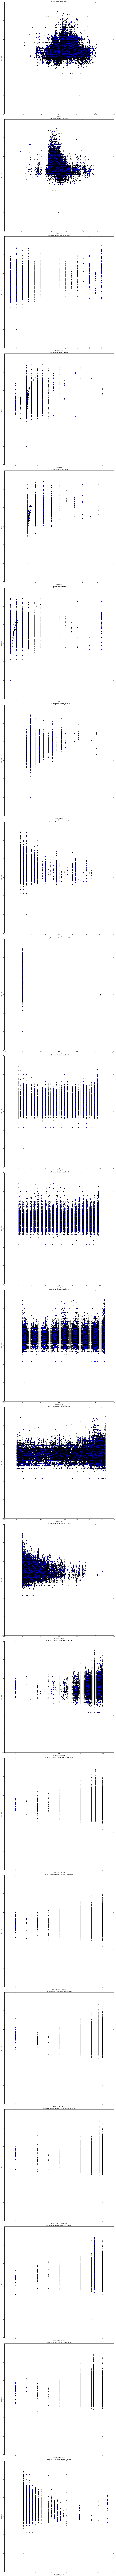

In [10]:
# visualize continuous random variables against response variable
# to determine if any transformations of the predictors would be helpful
cts_vars_to_plot = ['latitude', 'longitude',
                    'accommodates', 'bathrooms', 'bedrooms', 'beds', 
                    'guests_included', 'minimum_nights', 'maximum_nights',
                    'availability_30', 'availability_60', 'availability_90', 'availability_365',
                    'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy',
                    'review_scores_cleanliness', 'review_scores_checkin',
                    'review_scores_communication', 'review_scores_location',
                    'review_scores_value', 'host_listing_count']

fig, ax = plt.subplots(len(cts_vars_to_plot), figsize=(15, 15*len(cts_vars_to_plot)))
for i, var in enumerate(cts_vars_to_plot):
    ax[i].scatter(calendar_expanded_df[var], calendar_expanded_df['price_log_calendar'])
    ax[i].set_title('Log Price against ' + var)
    ax[i].set_xlabel(var)
    ax[i].set_ylabel('Log Price')

plt.tight_layout()
plt.show()

In [11]:
# transform variables determined to have nonlinear relationship with log price
calendar_expanded_df['longitude_sq'] = pd.to_numeric(calendar_expanded_df['longitude'], errors='raise')**2
calendar_expanded_df['review_scores_value_sq'] = calendar_expanded_df['review_scores_value']**2
calendar_expanded_df['host_listing_count_sq'] = calendar_expanded_df['host_listing_count']**2
calendar_expanded_df['longitude'] = pd.to_numeric(calendar_expanded_df['longitude'], errors='raise')

In [12]:
# create reasonable interaction terms
# time interacts with capacity of listing
calendar_expanded_df['weekend_x_bedrooms'] = calendar_expanded_df['weekend'] * calendar_expanded_df['bedrooms']
calendar_expanded_df['weekend_x_accommodates'] = calendar_expanded_df['weekend'] * calendar_expanded_df['accommodates']
calendar_expanded_df['holiday_x_bedrooms'] = calendar_expanded_df['holiday'] * calendar_expanded_df['bedrooms']
calendar_expanded_df['holiday_x_accommodates'] = calendar_expanded_df['holiday'] * calendar_expanded_df['accommodates']

In [13]:
# extract relevant feature listing
cts_vars = ['latitude', 'longitude', 
            'accommodates', 'bathrooms', 'bedrooms', 'beds', 
            'guests_included', 'minimum_nights', 'maximum_nights',
            'availability_30', 'availability_60', 'availability_90', 'availability_365',
            'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy',
            'review_scores_cleanliness', 'review_scores_checkin',
            'review_scores_communication', 'review_scores_location',
            'review_scores_value', 'host_listing_count', 'weekend_x_bedrooms',
            'weekend_x_accommodates', 'holiday_x_bedrooms', 'holiday_x_accommodates',
            'longitude_sq', 'review_scores_value_sq', 'host_listing_count_sq']

categorical_vars = ['zipcode_q1', 'zipcode_q2', 'zipcode_q3', 'zipcode_q4',
                   'neighborhood_q1', 'neighborhood_q2', 'neighborhood_q3', 'neighborhood_q4',
                   'weekend', 'holiday', 'slump', 'jan', 'feb', 'march'] + \
                    property_type_cols + is_location_exact_cols + room_type_cols + bed_type_cols

print 'continuous variables: ', cts_vars
print 'categorical variables:, ', categorical_vars

# grab X and y
all_predictors = cts_vars + categorical_vars
X_df = calendar_expanded_df[all_predictors].copy()
y_df = calendar_expanded_df[['price_log_calendar']].copy()

continuous variables:  ['latitude', 'longitude', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'guests_included', 'minimum_nights', 'maximum_nights', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'host_listing_count', 'weekend_x_bedrooms', 'weekend_x_accommodates', 'holiday_x_bedrooms', 'holiday_x_accommodates', 'longitude_sq', 'review_scores_value_sq', 'host_listing_count_sq']
categorical variables:,  ['zipcode_q1', 'zipcode_q2', 'zipcode_q3', 'zipcode_q4', 'neighborhood_q1', 'neighborhood_q2', 'neighborhood_q3', 'neighborhood_q4', 'weekend', 'holiday', 'slump', 'jan', 'feb', 'march', 'Apartment', 'Bed & Breakfast', 'Boat', 'Cabin', 'Camper/RV', 'Castle', 'Cave', 'Chalet', 'Dorm', 'Earth House', 'House', 'Hut', 'Lighthouse', 'Loft', 'Other', 'Tent', 

In [14]:
# numpy for sklearn
X = X_df.as_matrix()
y = y_df.as_matrix()

# Split into training and testing
Xy = np.concatenate((X, y), axis=1)
Xy = Xy[~np.isnan(Xy).any(axis=1)]

# use 75% for training, the rest for testing
num_train = int(np.round(Xy.shape[0]*0.75))

# shuffle for random selection
random.shuffle(Xy)

# pull out sets
X_train = Xy[:num_train,:(-1)]
X_test = Xy[num_train:,:(-1)]
y_train = Xy[:num_train, -1]
y_test = Xy[num_train:, -1]

X_train = np.nan_to_num(X_train)
X_test = np.nan_to_num(X_test)
y_train = np.nan_to_num(y_train)
y_test = np.nan_to_num(y_test)

In [15]:
# fit simple linear regression
linear_model = LinReg()
linear_model.fit(X_train, y_train)
print 'R^2 in test: ', linear_model.score(X_test, y_test)

R^2 in test:  0.628736337716


Hi Danny,
work from the numpy array Xy here. (Using any of the previous dataframes is risky because they may have NaNs and such)

In [36]:
Xy.shape

(7200423, 72)

Conclusions:
- when training we need to use a subset of our 7M observations for because using all the data takes too long
- Ridge/Lasso regressions didn't improve much over baseline linear regression
- random forest regression worked best

In [40]:
# sample a subset of data to train and cross-validate
# since 7M observations and 72 predictors takes 4+ hours to run for each time
n_samp = 1000000
sample_index = random.sample(range(0, Xy.shape[0]), n_samp)
df_x = Xy[sample_index, :-1]
df_y = Xy[sample_index, -1]

# standardize predictors for ridge regression
df_x = preprocessing.scale(df_x)


/Applications/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:167: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


In [41]:
# Generic function for cross-validation 
def AutoKFold(train_x, train_y, params1, params2, title):
    #Create a k-folds validation object
    kf = KFold(len(train_x), n_folds=5)
    #Record the mean score for each depth
    score_test = []
    score_train = []
    n = len(train_y)
    #print params1
    #Iterate over the parameters
    for param1 in params1:    
        for param2 in params2:
            #Record the score for each fold
            valid_score_test = []
            valid_score_train = []
            print param1
            #Iterate over the folds
            for train_index, test_index in kf:
                #Split x_train into a train and "test" set
                x_validate_train, x_validate_test = train_x[train_index], train_x[test_index]
                y_validate_train, y_validate_test = train_y[train_index], train_y[test_index]

                if title == 'Ridge': 
                    model = Ridge_Reg(alpha=param1)
                elif title == 'Lasso':
                    model = Lasso_Reg(alpha=param1)

                model.fit(x_validate_train, y_validate_train)
                
                #Compute the scores
                valid_score_test.append(model.score(x_validate_test, y_validate_test))
                valid_score_train.append(model.score(x_validate_train, y_validate_train))
            #Append the mean scores over the k-folds to score list
            score_test.append(np.mean(valid_score_test))
            score_train.append(np.mean(valid_score_train))
            
    return(np.concatenate((score_test, score_train)))

1e-07
1e-06
1e-05
0.0001
0.001
0.01
0.1
1.0
10.0
100.0
1000.0
10000.0
100000.0
1000000.0
10000000.0
[ 0.63696548  0.63696548  0.63696548  0.63696548  0.63696531  0.63694991
  0.63634176  0.63413692  0.63337109  0.63327779  0.63326331  0.6330411
  0.62892823  0.55305145  0.21002731  0.63703232  0.63703232  0.63703232
  0.63703232  0.63703214  0.6370166   0.63640801  0.63420308  0.63343726
  0.63334393  0.63332918  0.63310496  0.62898236  0.55308666  0.2100468 ]
(15,)


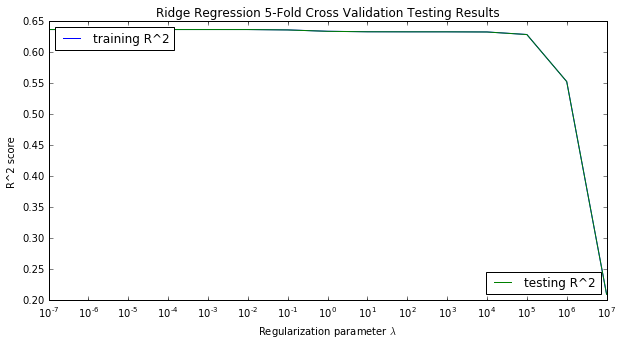

In [42]:
# tuning parameters for Ridge and LASSO regressions
lambda_lst = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7]
num_lambdas = len(lambda_lst)
num_predictors = Xy.shape[1]

# Ridge Regression
scores = AutoKFold(df_x, df_y, lambda_lst, [0], 'Ridge')

print scores
scores_test = scores[:num_lambdas]
scores_train = scores[num_lambdas:]
print scores_test.shape

ax = plt.figure(figsize=(10,5))
#h=plt.semilogx(10**np.array(lambda_lst), coeff_a);
h1=plt.semilogx(np.array(lambda_lst), scores_train);
h2=plt.semilogx(np.array(lambda_lst), scores_test);
plt.title('Ridge Regression 5-Fold Cross Validation Testing Results')
plt.ylabel("R^2 score")
plt.xlabel(r'Regularization parameter $\lambda$')
first_legend=plt.legend(h1, ['training R^2'], loc=2)
ax1 = plt.gca().add_artist(first_legend)
plt.legend(h2, ['testing R^2'], loc=4)
plt.show()

1e-07
1e-06
1e-05
0.0001
0.001
0.01
0.1
1.0
10.0
100.0
1000.0
10000.0
100000.0
1000000.0
10000000.0
[  6.33257262e-01   6.33257481e-01   6.33258742e-01   6.33253895e-01
   6.32896879e-01   6.23935551e-01   4.92698284e-01  -1.00327043e-05
  -1.00327043e-05  -1.00327043e-05  -1.00327043e-05  -1.00327043e-05
  -1.00327043e-05  -1.00327043e-05  -1.00327043e-05   6.33323440e-01
   6.33323636e-01   6.33324665e-01   6.33317973e-01   6.32957893e-01
   6.23992652e-01   4.92711729e-01   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00]
(15,)


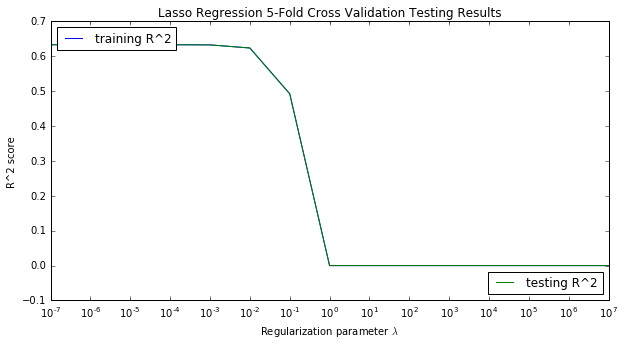

In [43]:
# Lasso Regression
scores = AutoKFold(df_x, df_y, lambda_lst, [0], 'Lasso')

print scores
scores_test = scores[:num_lambdas]
scores_train = scores[num_lambdas:]
print scores_test.shape

ax = plt.figure(figsize=(10,5))
h1=plt.semilogx(np.array(lambda_lst), scores_train);
h2=plt.semilogx(np.array(lambda_lst), scores_test);
plt.title('Lasso Regression 5-Fold Cross Validation Testing Results')
plt.ylabel("R^2 score")
plt.xlabel(r'Regularization parameter $\lambda$')
first_legend=plt.legend(h1, ['training R^2'], loc=2)
ax1 = plt.gca().add_artist(first_legend)
plt.legend(h2, ['testing R^2'], loc=4)
plt.show()

In [ ]:
# generic function to plot scores
def plot_CV_scores(score_train, score_test, index, index_label, title):
    fig, ax = plt.subplots(1, 1, figsize=(15, 5))

    ax.scatter(index, score_train, color='red', label='score_train')
    ax.plot(index, score_train, color='red')

    ax.scatter(index, score_test, color='blue', label='score_test')
    ax.plot(index, score_test, color='blue')

    ax.set_xlabel(index_label)
    ax.set_ylabel('Score')
    ax.set_title(title)
    ax.legend()

In [97]:
# Generic function for cross-validation 
def AutoKFold_RF(train_x, train_y, params1, params2, params3):
    #Create a k-folds validation object
    kf = KFold(len(train_x), n_folds=5)
    #Record the mean score for each depth
    score_test = []
    score_train = []
    n = len(train_y)
    #print params1
    #Iterate over the parameters
    for param1 in params1:    
        for param2 in params2:
            for param3 in params3:
                #Record the score for each fold
                valid_score_test = []
                valid_score_train = []
                #print param1
                #Iterate over the folds
                for train_index, test_index in kf:
                    #Split x_train into a train and "test" set
                    x_validate_train, x_validate_test = train_x[train_index], train_x[test_index]
                    y_validate_train, y_validate_test = train_y[train_index], train_y[test_index]

                    model = RandomForest(n_estimators=param1, max_depth=param2, max_features=param3)

                    model.fit(x_validate_train, y_validate_train)

                    #Compute the scores
                    valid_score_test.append(model.score(x_validate_test, y_validate_test))
                    valid_score_train.append(model.score(x_validate_train, y_validate_train))
                #Append the mean scores over the k-folds to score list
                score_test.append(np.mean(valid_score_test))
                score_train.append(np.mean(valid_score_train))

                print ("Trees:", param1, "Max_depth:", param2, "Max_features:", param3,
                       "Testing score:", round(np.mean(valid_score_test), 2), 
                       "Training score:", round(np.mean(valid_score_train), 2))

    return(np.concatenate((score_test, score_train)))

In [98]:
# sample a subset of data to train and cross-validate
# since 7M observations and 72 predictors takes 4+ hours to run for each time
n_samp = 10000
sample_index = random.sample(range(0, Xy.shape[0]), n_samp)
df_x = Xy[sample_index, :-1]
df_y = Xy[sample_index, -1]

# standardize predictors for ridge regression
df_x = preprocessing.scale(df_x)

In [99]:
# Random forest regression with 10,000 observations
n_trees = np.arange(10, 80, 30)  
depths = np.arange(2, 10)
features = np.arange(5, 70, 20)
n_combos = len(n_trees)*len(depths)*len(features)
print 'Number of combos: ', n_combos
scores = AutoKFold_RF(df_x, df_y, n_trees, depths, features)
scores_test = scores[:n_combos]
scores_train = scores[n_combos:]

Number of combos:  96
('Trees:', 10, 'Max_depth:', 2, 'Max_features:', 5, 'Testing score:', 0.34, 'Training score:', 0.34)
('Trees:', 10, 'Max_depth:', 2, 'Max_features:', 25, 'Testing score:', 0.51, 'Training score:', 0.51)
('Trees:', 10, 'Max_depth:', 2, 'Max_features:', 45, 'Testing score:', 0.5, 'Training score:', 0.51)
('Trees:', 10, 'Max_depth:', 2, 'Max_features:', 65, 'Testing score:', 0.51, 'Training score:', 0.51)
('Trees:', 10, 'Max_depth:', 3, 'Max_features:', 5, 'Testing score:', 0.41, 'Training score:', 0.42)
('Trees:', 10, 'Max_depth:', 3, 'Max_features:', 25, 'Testing score:', 0.57, 'Training score:', 0.58)
('Trees:', 10, 'Max_depth:', 3, 'Max_features:', 45, 'Testing score:', 0.58, 'Training score:', 0.59)
('Trees:', 10, 'Max_depth:', 3, 'Max_features:', 65, 'Testing score:', 0.57, 'Training score:', 0.58)
('Trees:', 10, 'Max_depth:', 4, 'Max_features:', 5, 'Testing score:', 0.5, 'Training score:', 0.5)
('Trees:', 10, 'Max_depth:', 4, 'Max_features:', 25, 'Testing scor

96
96


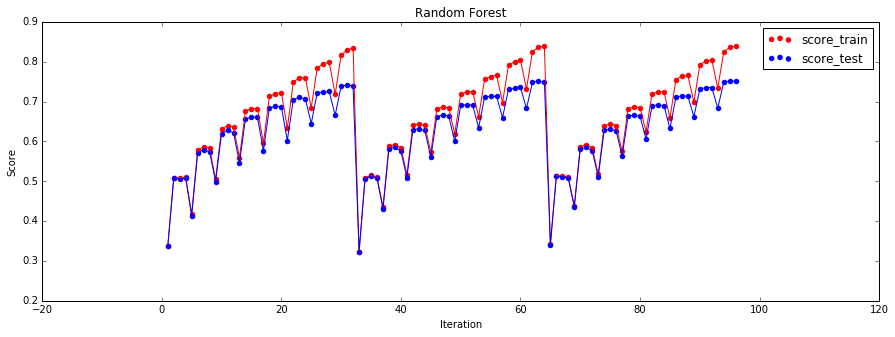

In [100]:
plot_CV_scores(scores_train, scores_test, range(1, n_combos+1), 'Iteration', 'Random Forest')

In [103]:
max(scores_test)

0.79880959806639906

In [101]:
# sample a subset of data to train and cross-validate
# since 7M observations and 72 predictors takes 4+ hours to run for each time
n_samp = 100000
sample_index = random.sample(range(0, Xy.shape[0]), n_samp)
df_x = Xy[sample_index, :-1]
df_y = Xy[sample_index, -1]

# standardize predictors for ridge regression
df_x = preprocessing.scale(df_x)


Number of combos:  64
('Trees:', 10, 'Max_depth:', 2, 'Max_features:', 5, 'Testing score:', 0.37, 'Training score:', 0.37)
('Trees:', 10, 'Max_depth:', 2, 'Max_features:', 25, 'Testing score:', 0.5, 'Training score:', 0.5)
('Trees:', 10, 'Max_depth:', 2, 'Max_features:', 45, 'Testing score:', 0.51, 'Training score:', 0.51)
('Trees:', 10, 'Max_depth:', 2, 'Max_features:', 65, 'Testing score:', 0.51, 'Training score:', 0.51)
('Trees:', 10, 'Max_depth:', 3, 'Max_features:', 5, 'Testing score:', 0.43, 'Training score:', 0.43)
('Trees:', 10, 'Max_depth:', 3, 'Max_features:', 25, 'Testing score:', 0.58, 'Training score:', 0.58)
('Trees:', 10, 'Max_depth:', 3, 'Max_features:', 45, 'Testing score:', 0.58, 'Training score:', 0.58)
('Trees:', 10, 'Max_depth:', 3, 'Max_features:', 65, 'Testing score:', 0.58, 'Training score:', 0.58)
('Trees:', 10, 'Max_depth:', 4, 'Max_features:', 5, 'Testing score:', 0.47, 'Training score:', 0.47)
('Trees:', 10, 'Max_depth:', 4, 'Max_features:', 25, 'Testing sco

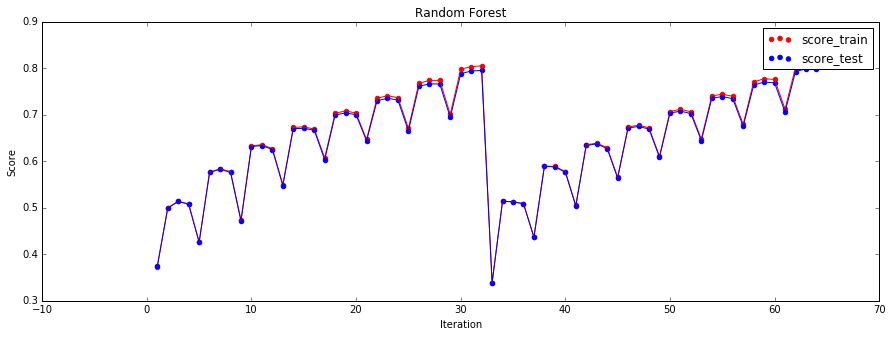

In [105]:
# Random forest regression with 100,000 observations
n_trees = np.arange(10, 50, 30)  
depths = np.arange(2, 10)
features = np.arange(5, 70, 20)
n_combos = len(n_trees)*len(depths)*len(features)
print 'Number of combos: ', n_combos
scores = AutoKFold_RF(df_x, df_y, n_trees, depths, features)
scores_test = scores[:n_combos]
scores_train = scores[n_combos:]

# plot scores
plot_CV_scores(scores_train, scores_test, range(1, n_combos+1), 'Iteration', 'Random Forest')

In [106]:
max(scores_test)

0.79881433296205073

Here we can see the the number of trees doesn't significantly change the testing score based on the step-wise nature of the testing scores. It is max_depth and max_features that drive increased test scores so we tune exclusively for those and set trees=40. We tune on 100,000 observations for run-time reasons.

Note: in lecture 16 it's recommended that for random forest max_features to be p/3 where p is the number of predictors. Also, random forests cannot overfit the data with respect to the number of trees, so we should first select the best max_depth and max_features for some "big enough" value for num_trees, and then re-tune with fixed max_depth and max_features while varying num_trees in order to find the minimum value for num_trees that gives us our best testing scores.

Number of combos:  133
('Trees:', 40, 'Max_depth:', 2, 'Max_features:', 5, 'Testing score:', 0.33, 'Training score:', 0.33)
('Trees:', 40, 'Max_depth:', 2, 'Max_features:', 15, 'Testing score:', 0.49, 'Training score:', 0.49)
('Trees:', 40, 'Max_depth:', 2, 'Max_features:', 25, 'Testing score:', 0.51, 'Training score:', 0.51)
('Trees:', 40, 'Max_depth:', 2, 'Max_features:', 35, 'Testing score:', 0.52, 'Training score:', 0.52)
('Trees:', 40, 'Max_depth:', 2, 'Max_features:', 45, 'Testing score:', 0.52, 'Training score:', 0.52)
('Trees:', 40, 'Max_depth:', 2, 'Max_features:', 55, 'Testing score:', 0.51, 'Training score:', 0.51)
('Trees:', 40, 'Max_depth:', 2, 'Max_features:', 65, 'Testing score:', 0.51, 'Training score:', 0.51)
('Trees:', 40, 'Max_depth:', 4, 'Max_features:', 5, 'Testing score:', 0.51, 'Training score:', 0.51)
('Trees:', 40, 'Max_depth:', 4, 'Max_features:', 15, 'Testing score:', 0.62, 'Training score:', 0.62)
('Trees:', 40, 'Max_depth:', 4, 'Max_features:', 25, 'Testing

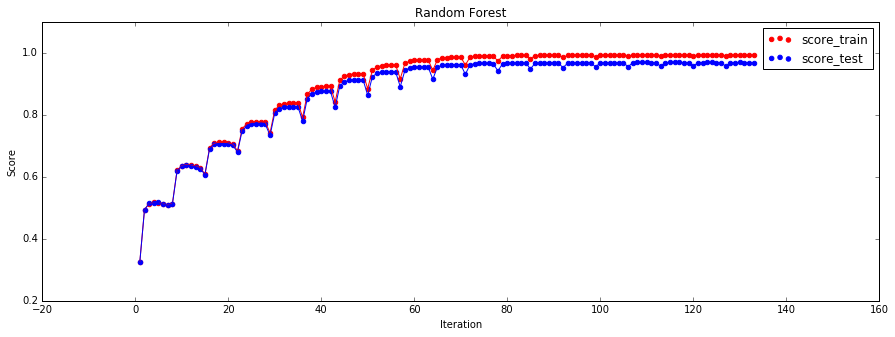

In [107]:
# Random forest regression with 100,000 observations tuning max_depth and max_features
n_trees = np.array([40])  
depths = np.arange(2, 40, 2)
features = np.arange(5, 70, 10)
n_combos = len(n_trees)*len(depths)*len(features)
print 'Number of combos: ', n_combos
scores = AutoKFold_RF(df_x, df_y, n_trees, depths, features)
scores_test = scores[:n_combos]
scores_train = scores[n_combos:]

# plot scores
plot_CV_scores(scores_train, scores_test, range(1, n_combos+1), 'Iteration', 'Random Forest')

Select max_depth=14 and max_features=25 for test score of 0.91. There were higher test scores up to 0.97 but those were for higher max_depth so I tried to pick lower values to avoid issues of over-fitting to our subsample


Number of combos:  10
('Trees:', 10, 'Max_depth:', 14, 'Max_features:', 25, 'Testing score:', 0.9, 'Training score:', 0.92)
('Trees:', 20, 'Max_depth:', 14, 'Max_features:', 25, 'Testing score:', 0.91, 'Training score:', 0.92)
('Trees:', 30, 'Max_depth:', 14, 'Max_features:', 25, 'Testing score:', 0.91, 'Training score:', 0.92)
('Trees:', 40, 'Max_depth:', 14, 'Max_features:', 25, 'Testing score:', 0.91, 'Training score:', 0.92)
('Trees:', 50, 'Max_depth:', 14, 'Max_features:', 25, 'Testing score:', 0.91, 'Training score:', 0.92)
('Trees:', 60, 'Max_depth:', 14, 'Max_features:', 25, 'Testing score:', 0.91, 'Training score:', 0.93)
('Trees:', 70, 'Max_depth:', 14, 'Max_features:', 25, 'Testing score:', 0.91, 'Training score:', 0.93)
('Trees:', 80, 'Max_depth:', 14, 'Max_features:', 25, 'Testing score:', 0.91, 'Training score:', 0.93)
('Trees:', 90, 'Max_depth:', 14, 'Max_features:', 25, 'Testing score:', 0.91, 'Training score:', 0.93)
('Trees:', 100, 'Max_depth:', 14, 'Max_features:', 2

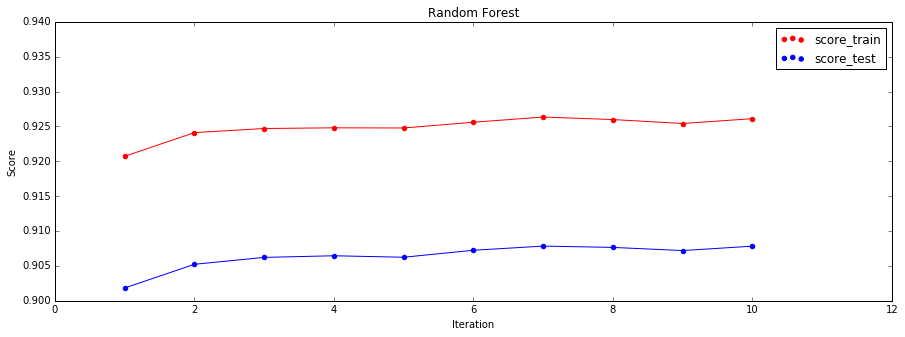

In [108]:
# Random forest regression with 100,000 observations tuning max_depth and max_features
n_trees = np.arange(10, 110, 10)
depths = np.array([14])
features = np.array([25])
n_combos = len(n_trees)*len(depths)*len(features)
print 'Number of combos: ', n_combos
scores = AutoKFold_RF(df_x, df_y, n_trees, depths, features)
scores_test = scores[:n_combos]
scores_train = scores[n_combos:]

# plot scores
plot_CV_scores(scores_train, scores_test, range(1, n_combos+1), 'Iteration', 'Random Forest')

Select num_trees=100, max_depth=14, and max_features=25 for test score of 0.91. We want to have the fewest number of trees possible while maintaining model score to decrease training time. However, in order to get an accurate prediction interval with our quantile regression forests method, we need to use more trees (200) as explained by: http://blog.datadive.net/prediction-intervals-for-random-forests/

In [60]:
# build final random forest regression model

# sample a subset of data to train and cross-validate
# since 7M observations and 72 predictors takes 4+ hours to run for each time
n_samp = 1000000
sample_index = random.sample(range(0, Xy.shape[0]), n_samp)
df_x = Xy[sample_index, :-1]
df_y = Xy[sample_index, -1]

# standardize predictors for ridge regression
df_x = preprocessing.scale(df_x)

# use 75% for training, the rest for testing
num_train = int(np.round(df_x.shape[0]*0.75))

# pull out sets
X_train = df_x[:num_train,:]
X_test = df_x[num_train:,:]
y_train = df_y[:num_train]
y_test = df_y[num_train:]

X_train = np.nan_to_num(X_train)
X_test = np.nan_to_num(X_test)
y_train = np.nan_to_num(y_train)
y_test = np.nan_to_num(y_test)

rf = RandomForest(n_estimators=1000, max_depth=14, max_features=25)
rf.fit(X_train, y_train)
print 'Score', round(rf.score(X_test, y_test), 2)

Score 0.92


In [63]:
# Use quantile regression forests to build 90% prediction interval
def pred_ints(model, X, percentile=95):
    err_down = []
    err_up = []
    for x in range(len(X)):
        preds = []
        for pred in model.estimators_:
            preds.append(pred.predict(X[x].reshape(1, -1))[0])
        err_down.append(np.percentile(preds, (100 - percentile) / 2. ))
        err_up.append(np.percentile(preds, 100 - (100 - percentile) / 2.))
    return err_down, err_up

In [64]:
# get predictions and 90% prediction interval
preds = rf.predict(X_test)
print preds
err_down, err_up = pred_ints(rf, X_test, percentile=90)

[ 4.2544405   5.15956824  4.7523481  ...,  4.3820096   5.11106386
  3.96469393]


In [65]:
# check how many of prediction intervals contained true value
truth = y_test
correct = 0.
for i, val in enumerate(truth):
    if err_down[i] <= val <= err_up[i]:
        correct += 1
print correct/len(truth)

0.830168


In [66]:
err_down[0:5]

[4.1271253250468494,
 4.9669589293328089,
 4.4037264621856762,
 4.8675344504555822,
 3.931255175817538]

In [67]:
preds[0:5]

array([ 4.2544405 ,  5.15956824,  4.7523481 ,  5.1672755 ,  4.25136859])

In [68]:
err_up[0:5]

[4.3929975209413312,
 5.3315331566423447,
 5.0178885294188795,
 5.401747432886876,
 4.7449321283632493]

Prediction interval contained the true y_test value ~80-90% of the time